In [1]:
import pandas as pd # package for high-performance, easy-to-use data structures and data analysis
import numpy as np # fundamental package for scientific computing with Python
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from PIL import Image, ImageDraw
import cv2

BASE_PATH = './data'
TRAIN_DIR = f'{BASE_PATH}/train'
TEST_DIR = f'{BASE_PATH}/test'

In [2]:
train = pd.read_csv(f'{BASE_PATH}/train.csv', index_col=0)
submission = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')

In [3]:
print('Size of train data', train.shape)
print('Size of submission file', submission.shape)

Size of train data (147793, 4)
Size of submission file (10, 2)


In [4]:
train.reset_index(inplace=True)
train.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [5]:
train_unique = train["image_id"].unique()
print('Number of unique images in train data is {} / {}'.format(len(train_unique), len(train)))

Number of unique images in train data is 3373 / 147793


In [6]:
bboxes = np.stack(train["bbox"].apply(lambda x: np.fromstring(x[1:-1], sep=",")))
for i, col in enumerate(["x_min", "y_min", "width", "height"]):
    train[col] = bboxes[:, i]

train["x_max"] = train["x_min"] + train["width"]
train["y_max"] = train["y_min"] + train["height"]
train.drop(columns=['bbox'], inplace=True)
train.head()

,image_id,width,height,source,x_min,y_min,x_max,y_max
0,b6ab77fd7,56.0,36.0,usask_1,834.0,222.0,890.0,258.0
1,b6ab77fd7,130.0,58.0,usask_1,226.0,548.0,356.0,606.0
2,b6ab77fd7,74.0,160.0,usask_1,377.0,504.0,451.0,664.0
3,b6ab77fd7,109.0,107.0,usask_1,834.0,95.0,943.0,202.0
4,b6ab77fd7,124.0,117.0,usask_1,26.0,144.0,150.0,261.0


In [7]:
range_checking = len(train[train["x_max"] > 1024]) + len(train[train["y_max"] > 1024]) + len(train[train["x_min"] < 0]) + len(train[train["y_min"] < 0])
print("Check range of bbox coordinates {}".format(range_checking))

Check range of bbox coordinates 0


In [8]:
train["class"] = 1
train.head()

,image_id,width,height,source,x_min,y_min,x_max,y_max,class
0,b6ab77fd7,56.0,36.0,usask_1,834.0,222.0,890.0,258.0,1
1,b6ab77fd7,130.0,58.0,usask_1,226.0,548.0,356.0,606.0,1
2,b6ab77fd7,74.0,160.0,usask_1,377.0,504.0,451.0,664.0,1
3,b6ab77fd7,109.0,107.0,usask_1,834.0,95.0,943.0,202.0,1
4,b6ab77fd7,124.0,117.0,usask_1,26.0,144.0,150.0,261.0,1


In [9]:
def check_file_exist(img_folder):
    extension_type = []
    file_list = os.listdir(img_folder)
    for f in file_list:
        extension_type.append(f.rsplit(".", 1)[1].lower())
    print(set(extension_type))
    print(len(set(extension_type)))

    
check_file_exist(TRAIN_DIR)

{'jpg'}
1


In [10]:
def check_img_size(img_folder):
    file_list = os.listdir(img_folder)
    counter = 0
    for f in file_list:
        try:
            img = cv2.imread(os.path.join(img_folder, f))
            height, width = img.shape[1], img.shape[0]
            
            if not ( height == 1024 and width == 1024 ):
                counter += 1
        except:
            print("Problem image {}".format(f))
    return counter

check_img_size(TRAIN_DIR)

0

In [11]:
train.head()

,image_id,width,height,source,x_min,y_min,x_max,y_max,class
0,b6ab77fd7,56.0,36.0,usask_1,834.0,222.0,890.0,258.0,1
1,b6ab77fd7,130.0,58.0,usask_1,226.0,548.0,356.0,606.0,1
2,b6ab77fd7,74.0,160.0,usask_1,377.0,504.0,451.0,664.0,1
3,b6ab77fd7,109.0,107.0,usask_1,834.0,95.0,943.0,202.0,1
4,b6ab77fd7,124.0,117.0,usask_1,26.0,144.0,150.0,261.0,1


In [12]:
def check_csv_imgs():
    anno_imgs = []
    imgs = [name.split(".")[0] for name in os.listdir(TRAIN_DIR)]
    for index, row in train.iterrows():
        anno_imgs.append(str(row.image_id))
    if set(imgs) == set(anno_imgs):
        print("Sanity Check Status: True")
    else:
        print("Sanity Check Status: Failed. \n"+\
              "The elements in wheat/train.csv but not in the train image folder is {} \n."+\
              "The elements in train image folder but not in wheat/train.csv is {1} ".format( (set(anno_imgs) - set(imgs)), (set(imgs) - set(anno_imgs))))
    return list(set(anno_imgs) - set(imgs)), list(set(imgs) - set(anno_imgs))

diff1, diff2 = check_csv_imgs()

print("There are {} images without annotations in the train/wheat.csv".format(len(diff2)))

Sanity Check Status: Failed. 
The elements in wheat/train.csv but not in the train image folder is {} 
.The elements in train image folder but not in wheat/train.csv is {'3116768f0', '952e7d15c', '8a5cb62db', 'c18c32da0', 'ffbb9c623', '65d0b13aa', 'ab20ec355', '91d4e3750', '8de789df8', 'd771bb084', 'f530a5d4b', 'ec196d18a', '49e40c7a4', '6584c18c0', '2d80f9c49', '45fddc611', 'a3ce975cd', 'c74ca81bd', 'cfc9040ca', 'b45c5294d', 'ccb3892c1', '39a0e5556', 'e4ec17f9b', 'd7e657453', '5cbd092f9', 'f9cafa47f', 'dd5d2fa9e', 'e01ad95cf', '5901a73fe', 'ed00a614d', '1a9792bfc', '0cf7ef43d', '69352f3fa', '526d737d1', 'f2a6804d2', 'cf1d2f504', '8425a537b', '581eaf87b', '7e1caf1f7', 'd83808467', '155c440e8', 'de2a3cf37', 'dec23c826', '83a94fc79', '9e21e7969', '00b5c6764', '0e7832f0b', '46c6a747a', '2e6c333a7'} 
There are 49 images without annotations in the train/wheat.csv


## Plot images with Bounding Box

In [13]:
def get_all_bboxes(df, image_id):
    image_bboxes = df[df.image_id == image_id]
    
    bboxes = []
    for _,row in image_bboxes.iterrows():
        bboxes.append((row.x_min, row.y_min, row.width, row.height))
        
    return bboxes
def plot_image_examples(df, rows=3, cols=3, title='Image examples'):
    fig, axs = plt.subplots(rows, cols, figsize=(10,10))
    for row in range(rows):
        for col in range(cols):
            idx = np.random.randint(len(df), size=1)[0]
            img_id = df.iloc[idx].image_id
            
            img = Image.open(os.path.join(TRAIN_DIR , img_id + '.jpg'))
            axs[row, col].imshow(img)
            
            bboxes = get_all_bboxes(df, img_id)
            
            for bbox in bboxes:
                rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
                axs[row, col].add_patch(rect)
            
            axs[row, col].axis('off')
            
    plt.suptitle(title)

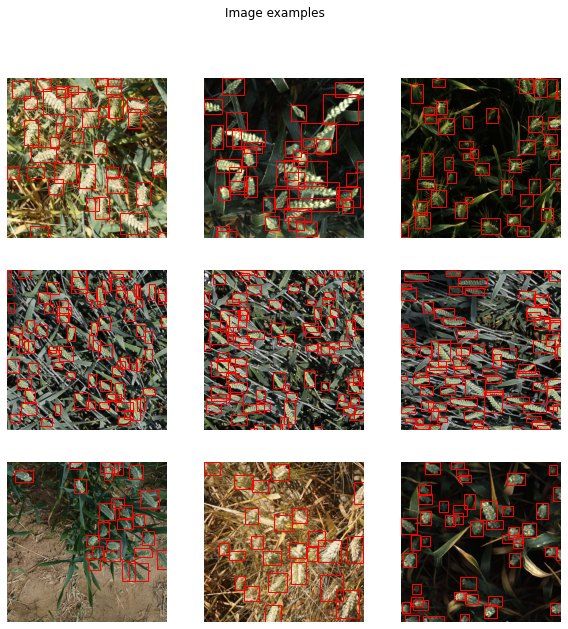

In [14]:
plot_image_examples(train, rows=3, cols=3, title='Image examples')

In [15]:
train.to_csv(f'{BASE_PATH}/wheat.csv', index=False)